### IMPORTS

In [1]:
import torch
torch.manual_seed(0)
import torchvision
import numpy as np
import torchvision.models as models
from IPython.display import display
import PIL
import ast
import cv2

from utils import preprocess_image

### TEST IMAGE

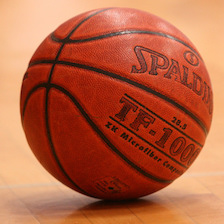

In [2]:
PINEAPLE_TEST_IMAGE_PATH = "./test_images/pineapple.jpg"
BASKETBALL_TEST_IMAGE_PATH = "./test_images/basketball.jpg"
SUBMARINE_TEST_IMAGE_PATH = "./test_images/submarine.jpg"
ZEBRA_TEST_IMAGE_PATH = "./test_images/zebra.jpg"

TEST_IMAGE = PIL.Image.open(BASKETBALL_TEST_IMAGE_PATH)
display(TEST_IMAGE)
preprocessed_image = preprocess_image(TEST_IMAGE)

### MODEL

In [3]:
model = models.resnet18(pretrained=True)
model.eval()
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

### CLASSES

In [4]:
classes_file = open("imagenet_classes.txt", "r")
classes = ast.literal_eval(classes_file.read())
classes_file.close()
print(classes)

{0: 'tench, Tinca tinca', 1: 'goldfish, Carassius auratus', 2: 'great white shark, white shark, man-eater, man-eating shark, Carcharodon carcharias', 3: 'tiger shark, Galeocerdo cuvieri', 4: 'hammerhead, hammerhead shark', 5: 'electric ray, crampfish, numbfish, torpedo', 6: 'stingray', 7: 'cock', 8: 'hen', 9: 'ostrich, Struthio camelus', 10: 'brambling, Fringilla montifringilla', 11: 'goldfinch, Carduelis carduelis', 12: 'house finch, linnet, Carpodacus mexicanus', 13: 'junco, snowbird', 14: 'indigo bunting, indigo finch, indigo bird, Passerina cyanea', 15: 'robin, American robin, Turdus migratorius', 16: 'bulbul', 17: 'jay', 18: 'magpie', 19: 'chickadee', 20: 'water ouzel, dipper', 21: 'kite', 22: 'bald eagle, American eagle, Haliaeetus leucocephalus', 23: 'vulture', 24: 'great grey owl, great gray owl, Strix nebulosa', 25: 'European fire salamander, Salamandra salamandra', 26: 'common newt, Triturus vulgaris', 27: 'eft', 28: 'spotted salamander, Ambystoma maculatum', 29: 'axolotl, mu

### RAW PREDICTION

In [5]:
output = model(preprocessed_image)
top_prediction = int(torch.argmax(output))
predicted_class = classes[top_prediction]
print(predicted_class)

basketball


### AREA IMPORTANCE HEATMAP WITH OCCLUSSIONS

In [6]:
loss_function = torch.nn.MSELoss()

def generate_area_importance_heatmap_with_occlusions(image, annotation, block_size=14):
    image = np.array(image)
    
    height, width, channels = image.shape
    
    columns = width // block_size
    rows =  height // block_size
    
    heatmap = np.zeros((columns, rows))
    
    for row in range(rows):
        for column in range(columns):
            x = column*block_size
            y = row*block_size
            
            top = int(y)
            left = int(x)
            right = left+block_size
            bottom = top+block_size
            
            tmp_image = np.copy(image)

            noise = np.random.rand(block_size, block_size, 3)*255
            tmp_image[int(top):int(bottom), int(left):int(right)] = noise
            tmp_image = PIL.Image.fromarray(tmp_image)
            
            preprocessed_image = preprocess_image(tmp_image)
            prediction = model(preprocessed_image).clamp(min=-1, max=1)
            loss = round(float(loss_function(prediction, annotation)), 4)
            
            heatmap[column, row] = loss

    heatmap = (heatmap - heatmap.min()) / (heatmap.max() - heatmap.min())
    heatmap = np.clip(heatmap, 0, 1)
    heatmap = heatmap * 255
    heatmap = np.uint8(heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    
    heatmap = cv2.resize(heatmap, (width, height), interpolation=cv2.INTER_NEAREST)
    heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)
    
    overlayed = cv2.addWeighted(image, 1, heatmap, 0.75, 0)
    combined = np.concatenate((image, heatmap, overlayed), axis=1)
    
    return combined

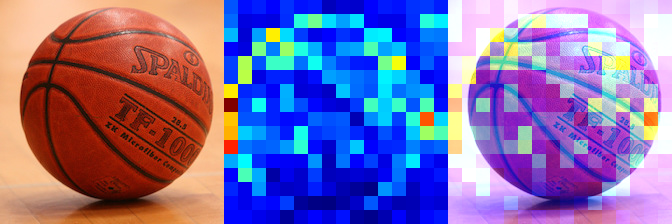

In [7]:
output = model(preprocessed_image)
occlusion_importance_heatmap = generate_area_importance_heatmap_with_occlusions(np.array(TEST_IMAGE), output)
display(PIL.Image.fromarray(occlusion_importance_heatmap))